In [14]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
import openai

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [15]:
class TaskPlan(TypedDict):
    name: str
    description: str
    expected_output: str

In [16]:
class ProblemDecomposition(MessagesState):
    input_problem: str
    decomposed: bool = False
    tasks: list[TaskPlan]

In [57]:
class Nodes:
    def __init__(self):
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0.5)
        self.eval_llm = ChatOpenAI(model="gpt-4o", temperature=0.7, stop_sequences=["<</STOP>>"])

    def intitial_problem_decomposition(self, state: ProblemDecomposition):
        system_prompt_text = """You are the AI component of a multi-agent AI system. Your task is to decompose a given problem into smaller tasks.
                                You always think before your answer. Always think on the language language of the user's input prompt."""
        
        suffix_instruction = """For first step specify some general tasks/problems/subquestion that's need to be solved to answer the
                            original question corretly. DO NOT decompose the task into too specific subtasks. I need more general one. These general
                            subtasks will be solved by special schemas."""
        
        prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt_text),
            ("human", "**User prompt:**\n{input_problem}\n---------\n" + suffix_instruction)
        ])

        chain = prompt | self.llm
        
        return {"messages": [*prompt.invoke(state["input_problem"]).to_messages(), chain.invoke(state["input_problem"])]}
    

    def self_evaluate(self, state: ProblemDecomposition):
        evaluation_prompt = """Check out the above generated tasks. Evalutate if they are relevant to solve or not relevant. 
                                In addition evaluate if they are general enough.
                                After the evaluation, say `<REFINE>` if you recommand to refine the tasks and says `<OK>` if refinement is not needed.
                                Be self-critical. In the refinement phase, you will decide whether to rephrase the task / group together more tasks / remove task from the list.
                                ALWAYS FINISH EVALUATION WITH `<OK><</STOP>>` or `<REFINE><</STOP>>` label."""
        
        prompt = ChatPromptTemplate.from_messages([
            *state["messages"],
            ("human", "{input}")
        ])

        chain = prompt | self.eval_llm

        context = [*prompt.invoke(evaluation_prompt).to_messages(), chain.invoke(evaluation_prompt)]

        if context[-1].content.endswith("<OK>"):
            return {
                "messages": context,
                "decomposed": True
            }
        else:
            return {
                "messages": context,
                "decomposed": False
            }
        

In [58]:
node = Nodes()

graph = StateGraph(ProblemDecomposition)
graph.add_node("problem_decomposition", node.intitial_problem_decomposition)
graph.add_node("self_evaluate", node.self_evaluate)

graph.add_edge(START, "problem_decomposition")
graph.add_edge("problem_decomposition", "self_evaluate")
graph.add_edge("self_evaluate", END)

graph = graph.compile()

In [39]:
from IPython.display import Image, display

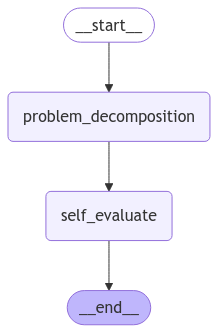

In [56]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
for task in graph.stream({"input_problem": "How to build a house?"}):
    print(task)
    print("_-------------------------_")

{'problem_decomposition': {'messages': [SystemMessage(content="You are the AI component of a multi-agent AI system. Your task is to decompose a given problem into smaller tasks.\n                                You always think before your answer. Always think on the language language of the user's input prompt.", additional_kwargs={}, response_metadata={}, id='0dd88847-10e0-4065-b5e5-bb791ec0e7c2'), HumanMessage(content="**User prompt:**\nHow to build a house?\n---------\nFor first step specify some general tasks/problems/subquestion that's need to be solved to answer the\n                            original question corretly. DO NOT decompose the task into too specific subtasks. I need more general one. These general\n                            subtasks will be solved by special schemas.", additional_kwargs={}, response_metadata={}, id='548c04ef-b163-46f5-8e65-11393a5cdf20'), AIMessage(content='To build a house, there are several general tasks or subquestions that need to be addres